# Intro to Art Neural Network with Keras

In [2]:
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### Perceptrons

In [3]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [4]:
y_pred

array([1])

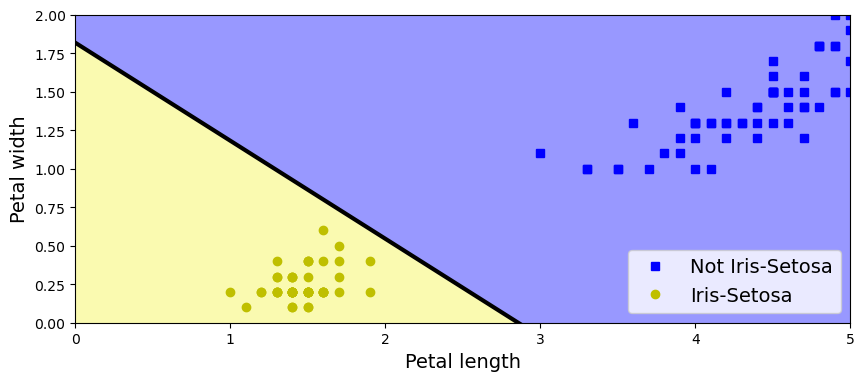

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

#### Activation Functions

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

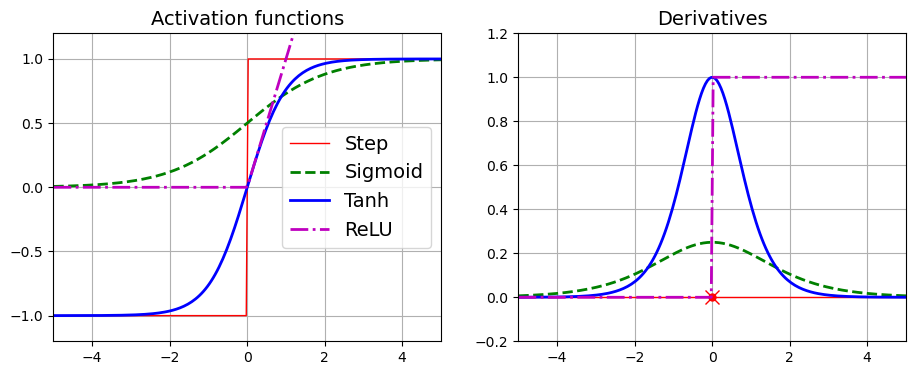

In [7]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [8]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

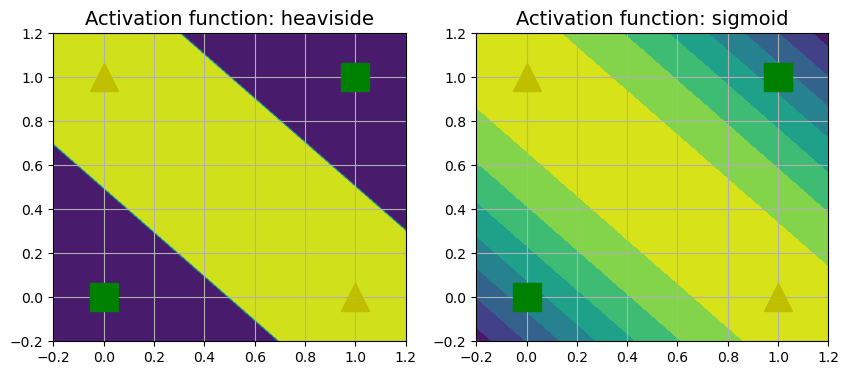

In [9]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

### Building an Image Classifier 

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
tf.__version__

'2.10.0'

In [12]:
keras.__version__

'2.10.0'

In [13]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [14]:
X_train_full.shape

(60000, 28, 28)

In [15]:
X_train_full.dtype

dtype('uint8')

In [16]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

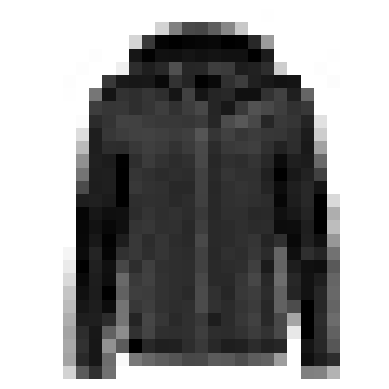

In [17]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [18]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [19]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [20]:
class_names[y_train[0]]

'Coat'

In [21]:
X_valid.shape

(5000, 28, 28)

In [22]:
X_test.shape

(10000, 28, 28)

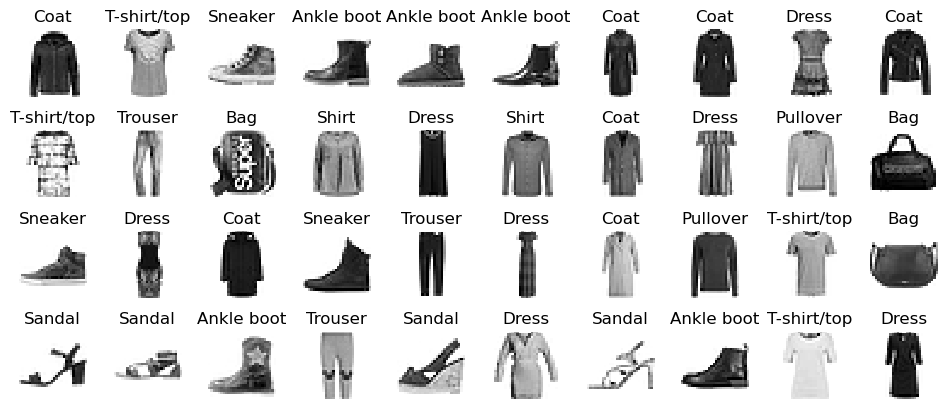

In [23]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### Creating the model using the Sequential API

In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2023-09-30 09:11:25.126472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.layers

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [29]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [31]:
model.get_layer(hidden1.name) is hidden1

True

In [32]:
weights, biases = hidden1.get_weights()

In [33]:
weights

array([[-0.00684669,  0.04416066,  0.04375166, ..., -0.03710638,
         0.0285417 ,  0.01939607],
       [-0.04586894,  0.0650721 ,  0.05164483, ...,  0.01458752,
         0.02047575,  0.04068153],
       [ 0.0193233 , -0.06337861, -0.01733334, ...,  0.02971161,
         0.05353718, -0.01235071],
       ...,
       [-0.03640175, -0.01147329, -0.05625857, ..., -0.04581907,
         0.00053678,  0.04716524],
       [-0.0647148 ,  0.05380961, -0.05653533, ...,  0.05496538,
         0.02302182, -0.03977774],
       [-0.0095685 , -0.03857972, -0.02485428, ...,  0.0280911 ,
        -0.02617394, -0.07166599]], dtype=float32)

In [34]:
weights.shape

(784, 300)

In [35]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [36]:
biases.shape

(300,)

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [38]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7377 - accuracy: 0.7557 - val_loss: 0.5295 - val_accuracy: 0.8146
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4949 - accuracy: 0.8254 - val_loss: 0.4421 - val_accuracy: 0.8484
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4461 - accuracy: 0.8417 - val_loss: 0.5263 - val_accuracy: 0.8020
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4179 - accuracy: 0.8538 - val_loss: 0.3958 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3987 - accuracy: 0.8595 - val_loss: 0.3825 - val_accuracy: 0.8654
Epoch 6/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3799 - accuracy: 0.8647 - val_loss: 0.3766 - val_accuracy: 0.8704
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3670 - accuracy: 0.8691 - val_loss: 0.3638 - val_accuracy:

#### Compiling the model

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2241 - accuracy: 0.9189 - val_loss: 0.2891 - val_accuracy: 0.8950
Epoch 2/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2211 - accuracy: 0.9203 - val_loss: 0.2896 - val_accuracy: 0.8950
Epoch 3/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2170 - accuracy: 0.9213 - val_loss: 0.3473 - val_accuracy: 0.8756
Epoch 4/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2142 - accuracy: 0.9238 - val_loss: 0.3065 - val_accuracy: 0.8900
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2129 - accuracy: 0.9234 - val_loss: 0.2845 - val_accuracy: 0.8962
Epoch 6/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2069 - accuracy: 0.9254 - val_loss: 0.3005 - val_accuracy: 0.8934
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2040 - accuracy: 0.9276 - val_loss: 0.2974 - val_accurac

In [41]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [42]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

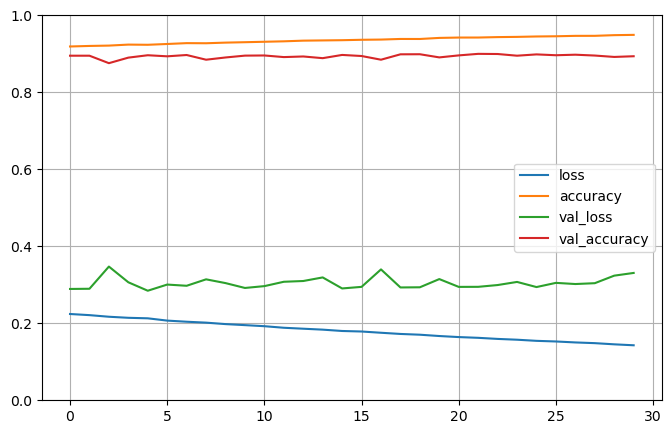

In [44]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [45]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3664 - accuracy: 0.8837


[0.36638036370277405, 0.8837000131607056]

#### Using the model to make predictions

In [46]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 309ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [47]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 22ms/step


array([9, 2, 1])

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [49]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

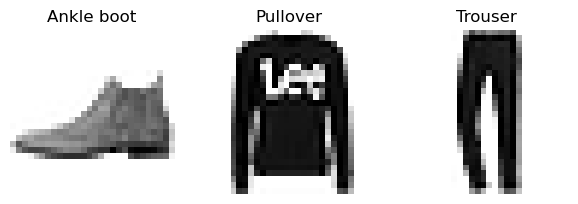

In [50]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Building a Regression MLP Using the Sequential API 

In [51]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 2.5155 - val_loss: 1.4927
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8133 - val_loss: 0.6748
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6785 - val_loss: 0.7500
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6378 - val_loss: 0.5802
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6056 - val_loss: 0.5500
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5781 - val_loss: 0.5656
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5566 - val_loss: 0.5772
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5385 - val_loss: 0.4921
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5209 - val_loss: 0.5007
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5070 - val_loss: 0.5155

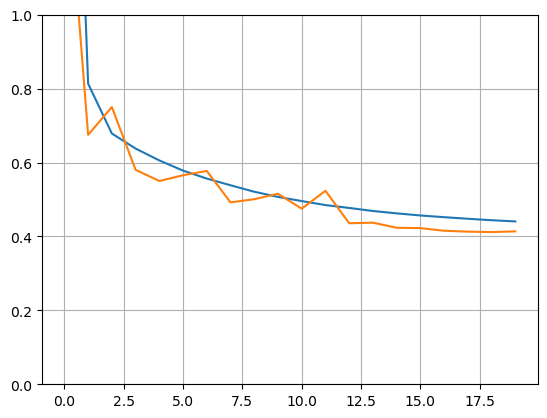

In [54]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
y_pred

array([[0.54399943],
       [1.5119693 ],
       [3.1387284 ]], dtype=float32)

### Building Complex Models Using the Functional API

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 30)           930         ['dense_5[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_6[0][0]']            

In [59]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 2.3121 - val_loss: 11.3137
Epoch 2/20
363/363 [==============================] - 1s 3ms/step - loss: 0.8294 - val_loss: 0.8841
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6579 - val_loss: 0.8926
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6252 - val_loss: 0.5624
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5893 - val_loss: 0.5410
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5600 - val_loss: 0.5496
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5382 - val_loss: 0.5658
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5208 - val_loss: 0.5124
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5008 - val_loss: 0.4721
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4860 - val_loss: 0.502

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [62]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 2.2257 - val_loss: 1.1468
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7540 - val_loss: 0.6788
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6575 - val_loss: 0.6173
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6130 - val_loss: 0.5879
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5822 - val_loss: 0.5528
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5554 - val_loss: 0.5303
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5344 - val_loss: 0.5026
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5159 - val_loss: 0.4863
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5000 - val_loss: 0.4729
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4868 - val_loss: 0.4567

#### Regularizing

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [66]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [67]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 3s 6ms/step - loss: 2.3256 - main_output_loss: 2.1435 - aux_output_loss: 3.9646 - val_loss: 1.2765 - val_main_output_loss: 0.9368 - val_aux_output_loss: 4.3336
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9451 - main_output_loss: 0.7885 - aux_output_loss: 2.3546 - val_loss: 1.1663 - val_main_output_loss: 0.7055 - val_aux_output_loss: 5.3140
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7827 - main_output_loss: 0.6729 - aux_output_loss: 1.7714 - val_loss: 1.1238 - val_main_output_loss: 0.6578 - val_aux_output_loss: 5.3183
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7132 - main_output_loss: 0.6200 - aux_output_loss: 1.5522 - val_loss: 1.0348 - val_main_output_loss: 0.6024 - val_aux_output_loss: 4.9267
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6738 - main_output_loss: 0.5875 - aux_output_loss: 1.4507 - val_loss

In [68]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

1/1 [==============================] - 0s 156ms/step


### Using the Subclassing API to Build Dynamic Models

In [69]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

### Saving & Restoring a Model

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [72]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.8563 - val_loss: 2.3872
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6940 - val_loss: 1.2400
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6188 - val_loss: 0.8172
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5764 - val_loss: 0.6605
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5463 - val_loss: 0.5625
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5213 - val_loss: 0.5149
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5015 - val_loss: 0.4817
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4844 - val_loss: 0.4612
Epoch 9/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4701 - val_loss: 0.4460
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4449


In [73]:
model.save("my_keras_model.h5")

In [74]:
model = keras.models.load_model("my_keras_model.h5")

In [75]:
model.predict(X_new)

1/1 [==============================] - 0s 55ms/step


array([[0.88225615],
       [1.3382041 ],
       [3.5124369 ]], dtype=float32)

In [76]:
model.save_weights("my_keras_weights.ckpt")

In [77]:
model.load_weights("my_keras_weights.ckpt")

### Using Callbacks

In [78]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [80]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.5493 - val_loss: 1.9909
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7697 - val_loss: 0.9337
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6640 - val_loss: 0.6627
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6051 - val_loss: 0.5899
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5628 - val_loss: 0.5339
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5285 - val_loss: 0.5032
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5021 - val_loss: 0.4744
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4812 - val_loss: 0.4549
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4650 - val_loss: 0.4412
Epoch 10/10
162/162 [==============================] - 0s 2ms/step - loss: 0.4391


In [81]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4422 - val_loss: 0.4270
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4343 - val_loss: 0.4310
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4278 - val_loss: 0.4219
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4221 - val_loss: 0.4254
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4177 - val_loss: 0.4152
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4134 - val_loss: 0.4242
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4098 - val_loss: 0.4205
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4065 - val_loss: 0.4117
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4035 - val_loss: 0.4152
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4007 - val_lo

In [82]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [83]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

334/363 [==========================>...] - ETA: 0s - loss: 0.4007
val/train: 1.03
363/363 [==============================] - 1s 2ms/step - loss: 0.4035 - val_loss: 0.4169


### Using TensorBoard for Visualization